# Experiment 2.2 #

Augmenting mnist dataset by rescaling, relocating and adding Gaussian noise

Experimenting with CNN (with Maxpooling layers)

Note: CNN model with Maxpooling layers is unable to learn the task



In [1]:
#@title  { form-width: "30%" }

max_scale = 2.5 #@param {type:"number"}
min_scale = 0.8 #@param {type:"number"}
gauss_var = 0.3 #@param {type:"number"}

In [1]:
import matplotlib.pyplot as plt

from utils.visualize import *
from utils.preprocess import *
from utils.save_load import *

import numpy as np
import tensorflow as tf


from keras.datasets import mnist
from keras.models import Sequential, load_model


from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, AveragePooling2D, MaxPooling2D

from keras.regularizers import l2
from keras.utils import np_utils
from keras import backend as K
from keras import optimizers
from keras import models

from sklearn.model_selection import train_test_split


Using TensorFlow backend.


## preprocess data for experiement 2:
    random scaling and random location with gaussian noise

In [3]:
## preprocess data for experiement 1

(X_train, y_train), (X_test, y_test) = mnist.load_data()



In [4]:
X_train = augment(X_train, output_size=192, resize_scale = (min_scale, max_scale),
                  add_noise=True, gauss_var = gauss_var)
X_test = augment(X_test, output_size=192, resize_scale = (min_scale, max_scale), 
                 add_noise=True, gauss_var = gauss_var)


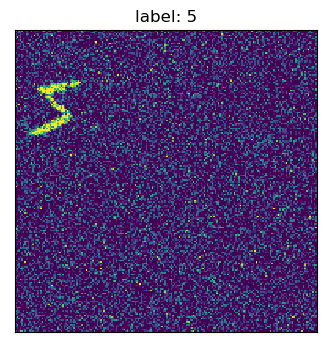

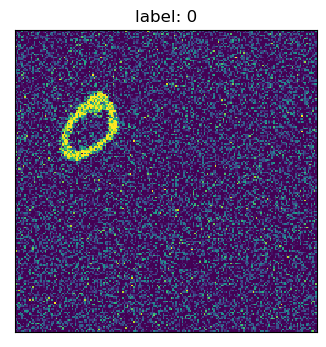

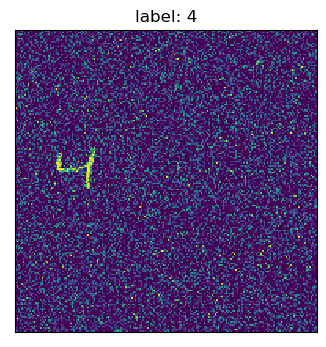

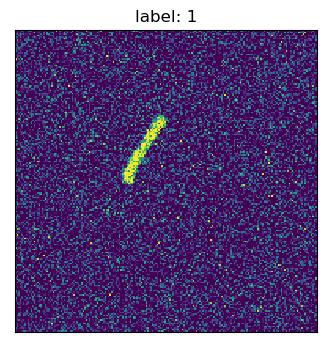

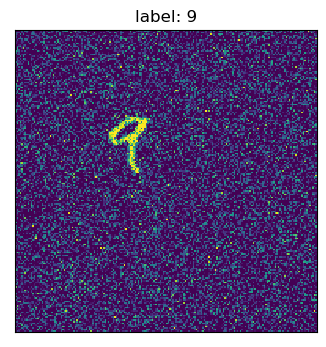

In [3]:
for i in range(5):
    show_img(img = X_train[i], label = y_train[i])

In [4]:


# reshape to be [samples][pixels][width][height]
size = X_train.shape[1]
X_train = X_train.reshape(X_train.shape[0], 1, size, size).astype('float32')


X_test = X_test.reshape(X_test.shape[0], 1, size, size).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255

X_test = X_test / 255


#split test set to val and test set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, 
												random_state=0)

# one-hot encode outputs
# y_train = np_utils.to_categorical(y_train)
# y_test = np_utils.to_categorical(y_test)
# y_val = np_utils.to_categorical(y_val)

In [5]:
print(X_train.shape)

(54000, 1, 192, 192)


In [6]:
# save preprcessed data as npz
save_as_npz(X_val, y_val, name = "noise_rescaled_relocated_", set_type="val")
save_as_npz(X_train, y_train, name = "noise_rescaled_relocated_", set_type="train")
save_as_npz(X_test, y_test, name = "noise_rescaled_relocated_", set_type="test")

# Building model

In [3]:
print(tf.test.gpu_device_name())
K.set_image_dim_ordering('th')

/device:GPU:0


In [4]:
#@title configuration and hyperparameters { form-width: "30%" }
seed = 7 #@param {type:"integer"}

epoch_num = 20 #@param {type:"integer"}

batch_size = 128 #@param {type:"integer"}

optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, 
                            decay=0.0, amsgrad=False)

size = 192
np.random.seed(seed)


In [13]:
#@title  { form-width: "30%" }

experiment_index = 2 #@param {type:"integer"}
experiment_subindex = 2 #@param {type:"integer"}
kernel_size = 5
def build_model(size, opt="adam"):
	# create model
	model = Sequential()
	model.add(Conv2D(64, (kernel_size, kernel_size), input_shape=(1, size, size), 
                     activation='relu', 
                     name="conv_{}x{}_1".format(kernel_size,kernel_size)))
	model.add(MaxPooling2D(pool_size=(2, 2), name = "MaxPool_2x2_1"))
	model.add(Dropout(0.3, name = "drop_1"))

	model.add(Conv2D(64, (kernel_size, kernel_size), activation='relu', 
                     name="conv_{}x{}_2".format(kernel_size,kernel_size)))
	model.add(MaxPooling2D(pool_size=(2, 2),name="MaxPool_2x2_2"))
	model.add(Dropout(0.3, name = "drop_2"))

	model.add(Conv2D(32, (kernel_size, kernel_size), activation='relu', 
                     name="conv_{}x{}_3".format(kernel_size,kernel_size)))
	model.add(MaxPooling2D(pool_size=(2, 2), name="MaxPool_2x2_3"))

# 	model.add(Conv2D(32, (5, 5), activation='relu'))
# 	model.add(MaxPooling2D(pool_size=(2, 2)))
	
	model.add(Flatten(name="flatten"))
	model.add(Dropout(0.35, name = "drop_3"))

	model.add(Dense(128, activation='relu', 
            kernel_regularizer=l2(0.),
                    name="dense_1"
        ))
	model.add(Dropout(0.3, name = "drop_4"))
    
	model.add(Dense(10, activation='softmax', 
        kernel_regularizer=l2(0.),
                    name="dense_2"
        ))
	# Compile model
	model.compile(loss='categorical_crossentropy', 
					optimizer=opt, metrics=['accuracy'])
	return model

model = build_model(size, opt=optimizer)

model.save('models/experiment_{}.{}.h5'.format(experiment_index, experiment_subindex))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_5x5_1 (Conv2D)          (None, 64, 188, 188)      1664      
_________________________________________________________________
MaxPool_2x2_1 (MaxPooling2D) (None, 64, 94, 94)        0         
_________________________________________________________________
drop_1 (Dropout)             (None, 64, 94, 94)        0         
_________________________________________________________________
conv_5x5_2 (Conv2D)          (None, 64, 90, 90)        102464    
_________________________________________________________________
MaxPool_2x2_2 (MaxPooling2D) (None, 64, 45, 45)        0         
_________________________________________________________________
drop_2 (Dropout)             (None, 64, 45, 45)        0         
_________________________________________________________________
conv_5x5_3 (Conv2D)          (None, 32, 41, 41)        51232     
__________

# Training model

In [31]:
X_test, y_test = load_data_from_npz(size=192, name="noise_rescaled_relocated_", set_type="test")

In [ ]:
y_train_onehot = np_utils.to_categorical(y_train, num_classes=10)
y_val_onehot = np_utils.to_categorical(y_val, num_classes=10)
y_test_onehot = np_utils.to_categorical(y_test, num_classes=10)
assert y_train_onehot.shape == (54000, 10)
assert y_val_onehot.shape == (6000, 10)
assert y_test_onehot.shape == (10000, 10)

In [ ]:
experiment_index, experiment_subindex = (2,2)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
					epochs=epoch_num, 
					batch_size=batch_size, verbose=1)

model.save_weights('weights/experiment_{}_{}.h5'.format(experiment_index, experiment_subindex))


# Evaluation

In [2]:
# load model with max pooling layer
# load weights of model with averagepooling layer
# experiment_index, experiment_subindex = 2,0

new_model = load_model('models/experiment_{}_{}.h5'.format(2,2))
new_model.load_weights('weights/experiment_{}_{}.h5'.format(2,0))

W0801 11:47:39.236527 139626244646656 deprecation_wrapper.py:119] From /home/dattran/miniconda3/envs/hieu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0801 11:47:39.246870 139626244646656 deprecation_wrapper.py:119] From /home/dattran/miniconda3/envs/hieu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0801 11:47:39.254348 139626244646656 deprecation_wrapper.py:119] From /home/dattran/miniconda3/envs/hieu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0801 11:47:39.254795 139626244646656 deprecation_wrapper.py:119] From /home/dattran/miniconda3/envs/hieu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is d

In [3]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_5x5_1 (Conv2D)          (None, 64, 188, 188)      1664      
_________________________________________________________________
MaxPool_2x2_1 (MaxPooling2D) (None, 64, 94, 94)        0         
_________________________________________________________________
drop_1 (Dropout)             (None, 64, 94, 94)        0         
_________________________________________________________________
conv_5x5_2 (Conv2D)          (None, 64, 90, 90)        102464    
_________________________________________________________________
MaxPool_2x2_2 (MaxPooling2D) (None, 64, 45, 45)        0         
_________________________________________________________________
drop_2 (Dropout)             (None, 64, 45, 45)        0         
_________________________________________________________________
conv_5x5_3 (Conv2D)          (None, 32, 41, 41)        51232     
__________

In [34]:
# error on maxpooling model with weights from averagepooling model

y_test_onehot = np_utils.to_categorical(y_test, num_classes=10)
assert y_test_onehot.shape == (10000, 10)
scores = new_model.evaluate(X_test, y_test_onehot, verbose=1)
print("Baseline Error on test set: %.2f%%" % (100-scores[1]*100))



# # write results to text file
# with open("Results_experiment_{}_{}.txt".format(experiment_index, experiment_subindex),"w") as f:
#     f.write("model: 4 conv, average pooling, 2 dense\n")
#     f.write("data: permutation \n")
#     f.write("Accuracy: " + str(scores[1]))

10000/10000 [==============================] - 5s 538us/step
Baseline Error on test set: 4.37%


In [ ]:
# plot accuracy

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy\ntest accuracy: ' + str(scores[1]))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='lower right')
plt.savefig('histories/acc_experiment_{}_{}.png'.format(experiment_index, experiment_subindex),bbox_inches='tight')
plt.show()

In [ ]:
# plot loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper right')
plt.savefig('histories/loss_experiment_{}_{}.png'.format(experiment_index, experiment_subindex),bbox_inches='tight')
plt.show()

# Results

Experiment 1 : accuracy 98.3%

Experiment 2 : accuracy 97.3% (average pooling model)

Experiment 2.2 : accuracy 95.6% (max pooling model using weights from experiment 2)

Experiment 3 : accuracy 56.9%

Experiment 4 : accuracy 11.3%

# load model and visualize output


In [2]:
experiment_index, experiment_subindex = 2,0

new_model = load_model('models/experiment_{}_{}.h5'.format(experiment_index, experiment_subindex))
new_model.load_weights('weights/experiment_{}_{}.h5'.format(experiment_index, experiment_subindex))

W0801 11:50:28.428703 139946428561152 deprecation_wrapper.py:119] From /home/dattran/miniconda3/envs/hieu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0801 11:50:28.444056 139946428561152 deprecation_wrapper.py:119] From /home/dattran/miniconda3/envs/hieu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0801 11:50:28.454276 139946428561152 deprecation_wrapper.py:119] From /home/dattran/miniconda3/envs/hieu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0801 11:50:28.454706 139946428561152 deprecation_wrapper.py:119] From /home/dattran/miniconda3/envs/hieu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is d

64  channels


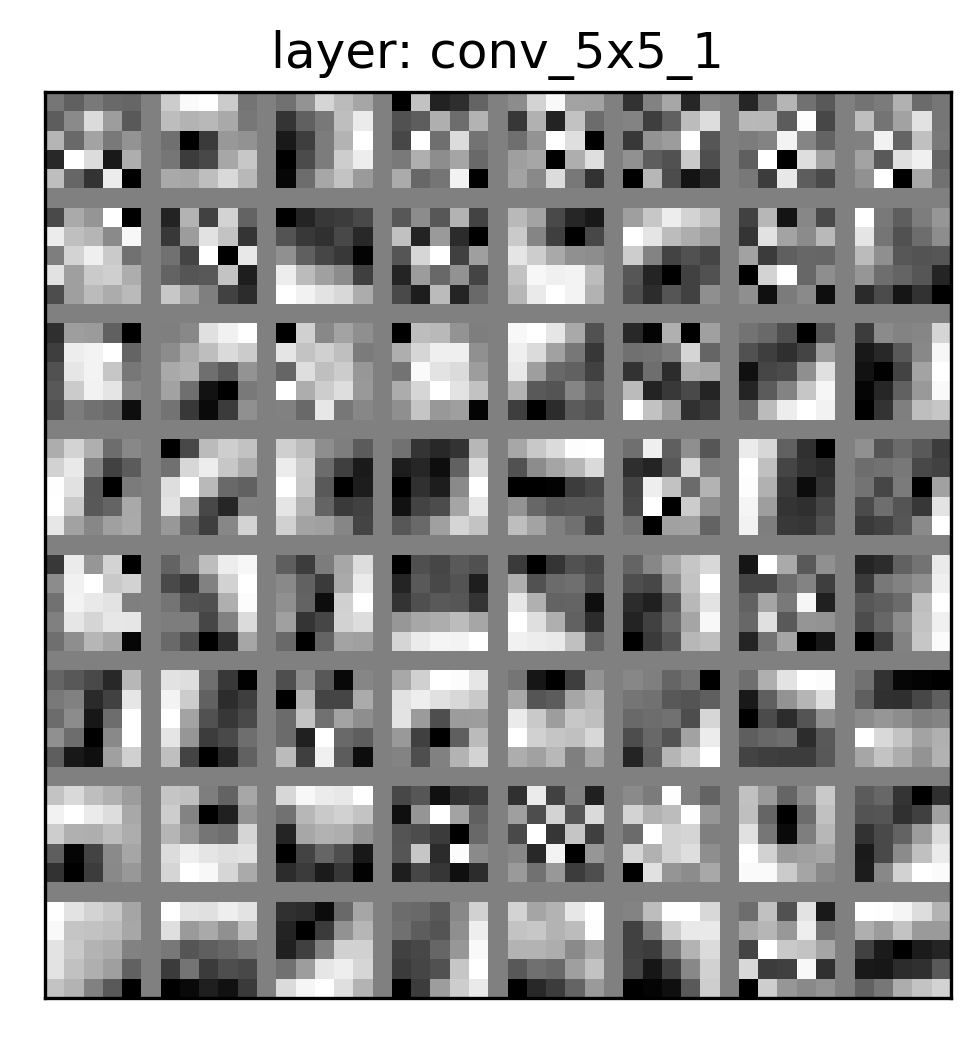

4096  channels


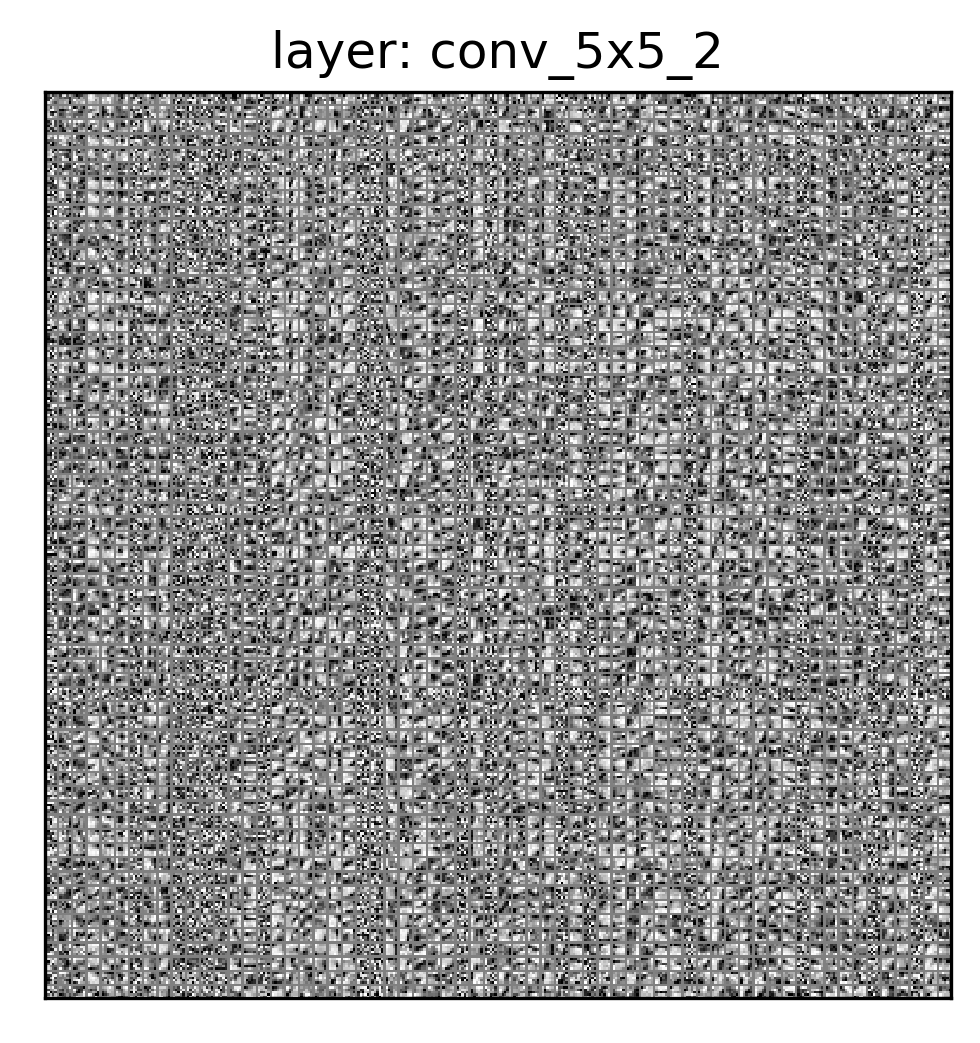

2048  channels


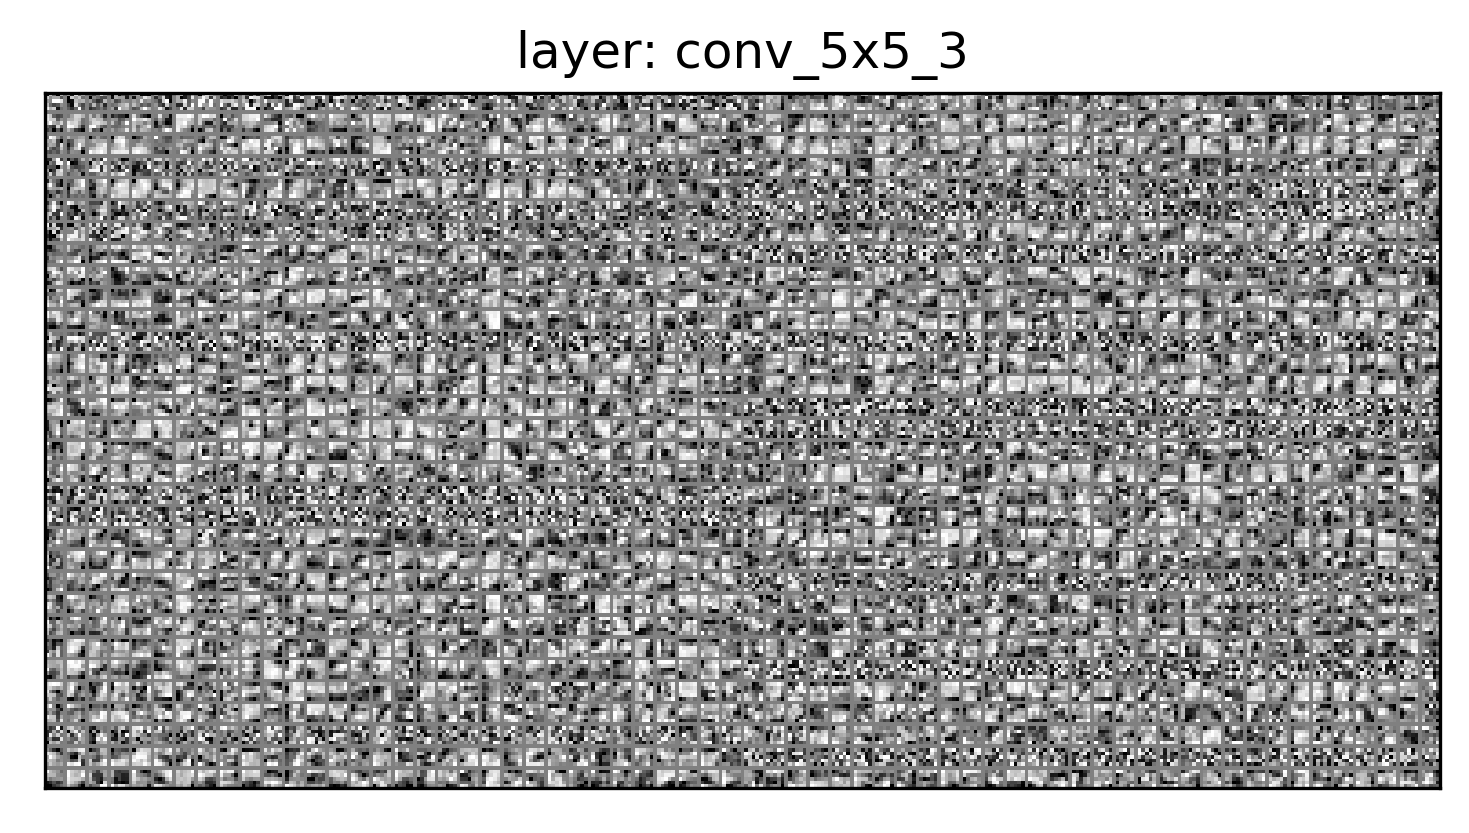

In [3]:
# weights of shape (5,5,m,n) is display as m*n 5x5 images for m*n channels
visualize_weights(new_model)

In [4]:
X_test, y_test = load_data_from_npz(size=192, name="1noise_rescaled_relocated_", set_type="test")

In [37]:
digit = 5
mask = (y_test == digit);
indices_1 = np.arange(y_test.shape[0])[mask]
y_1 = y_test[indices_1]
X_1 = X_test[indices_1]
# mask

image 0


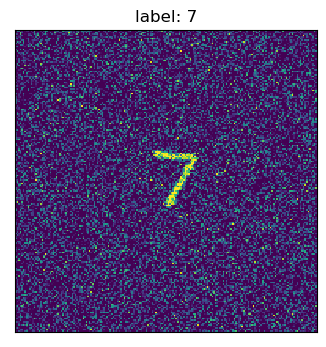

image 1


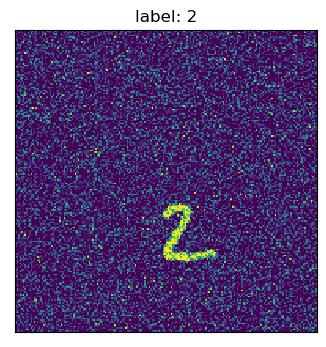

image 2


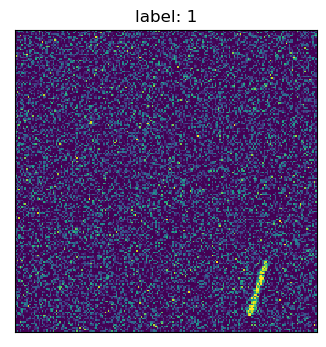

image 3


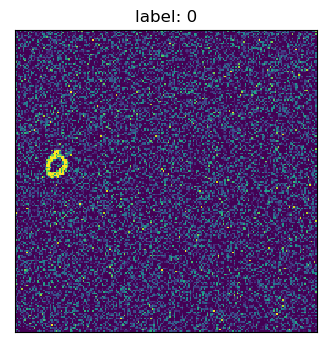

image 4


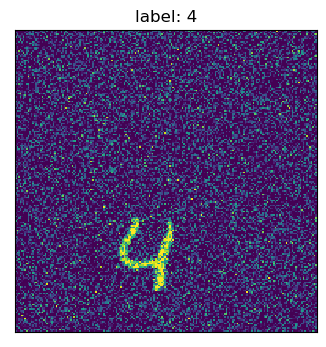

In [6]:
for i in range(5):
    print("image", i)
    show_img(X_test[i][0],y_test[i], dpi = 100)

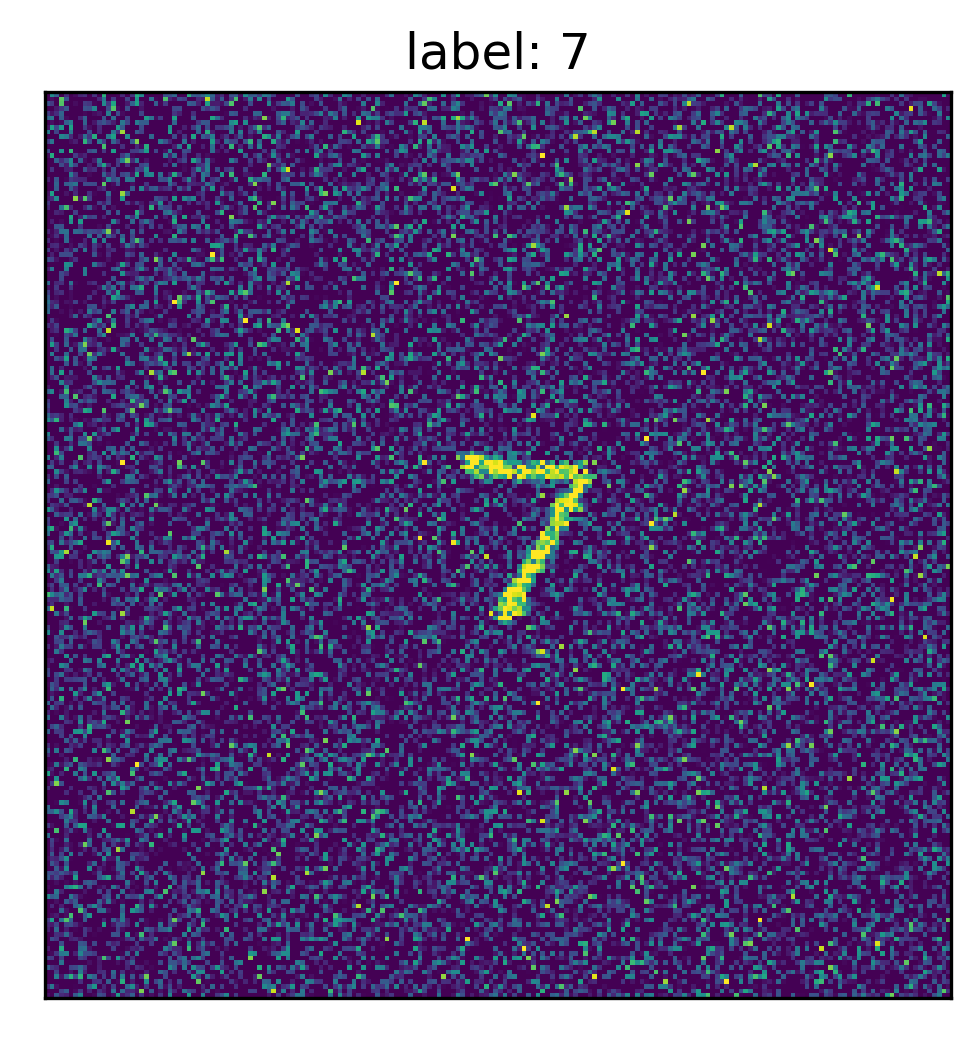

64  channels


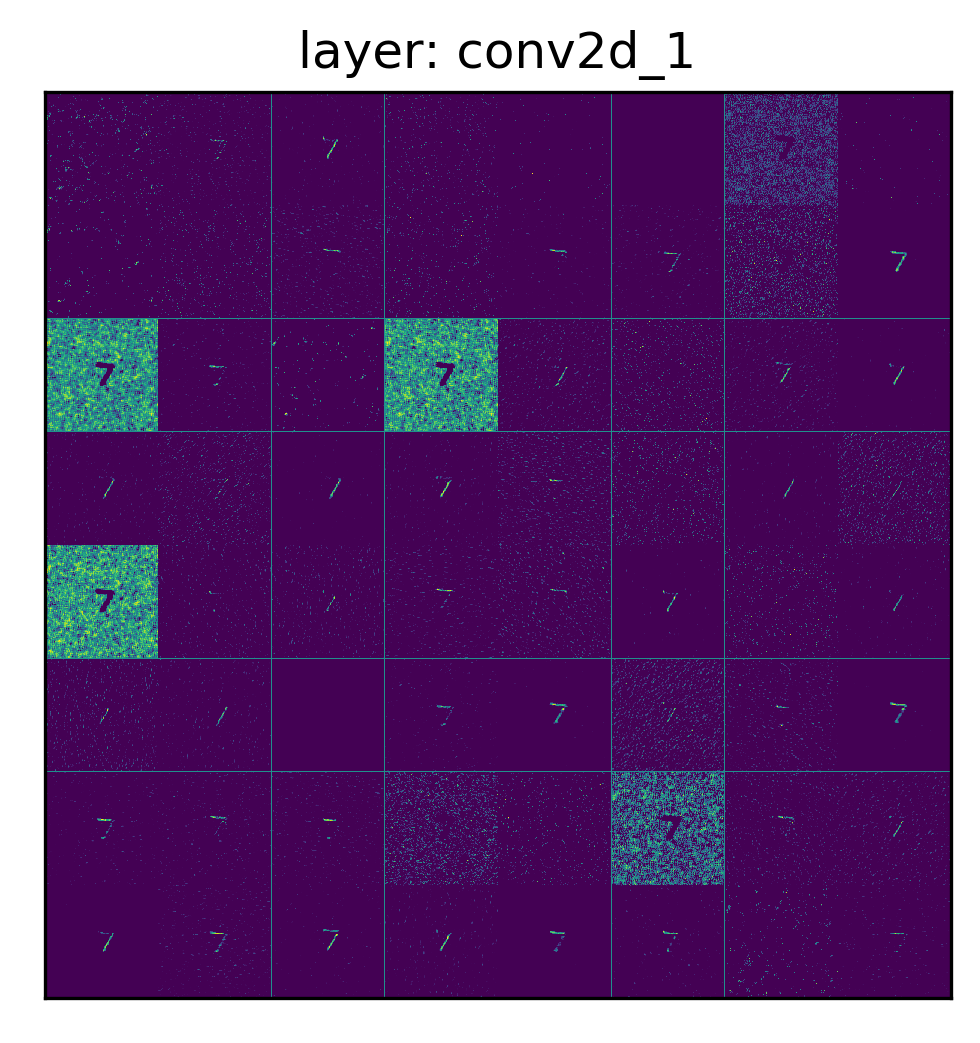

64  channels


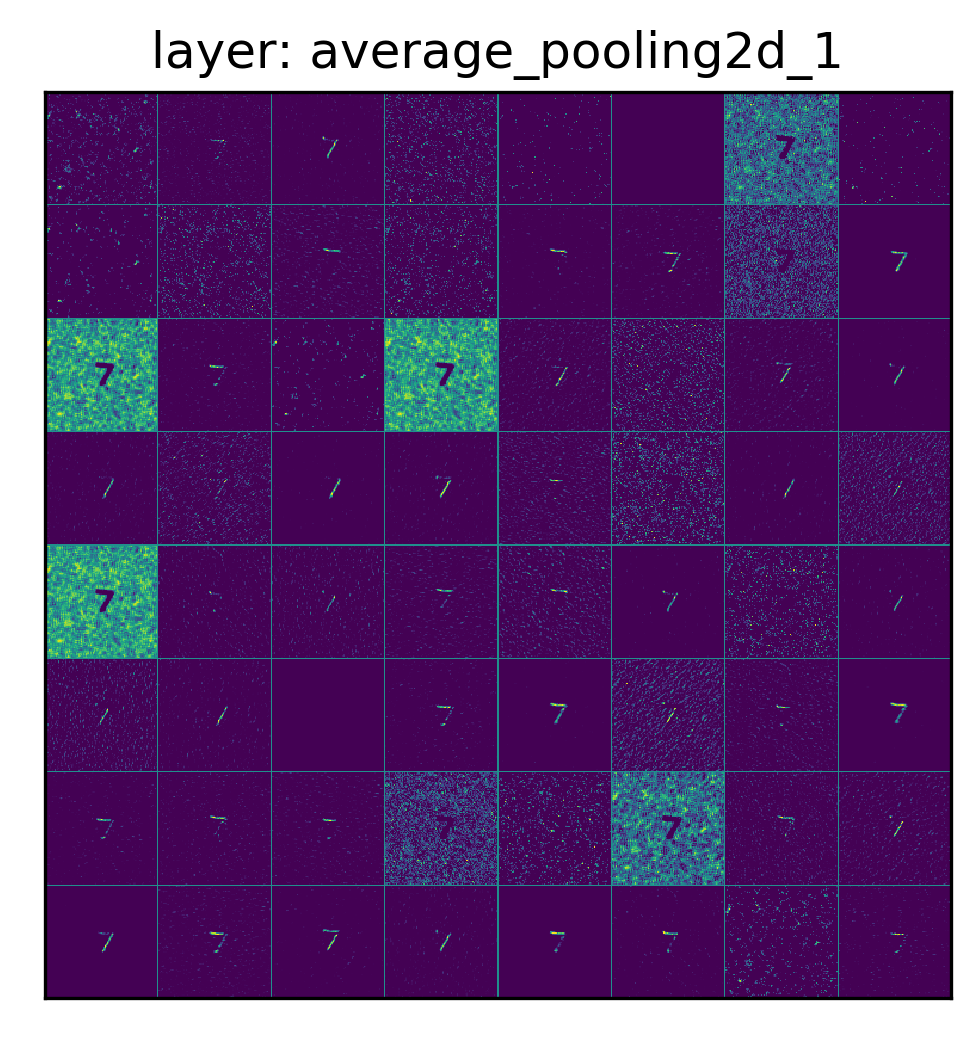

64  channels


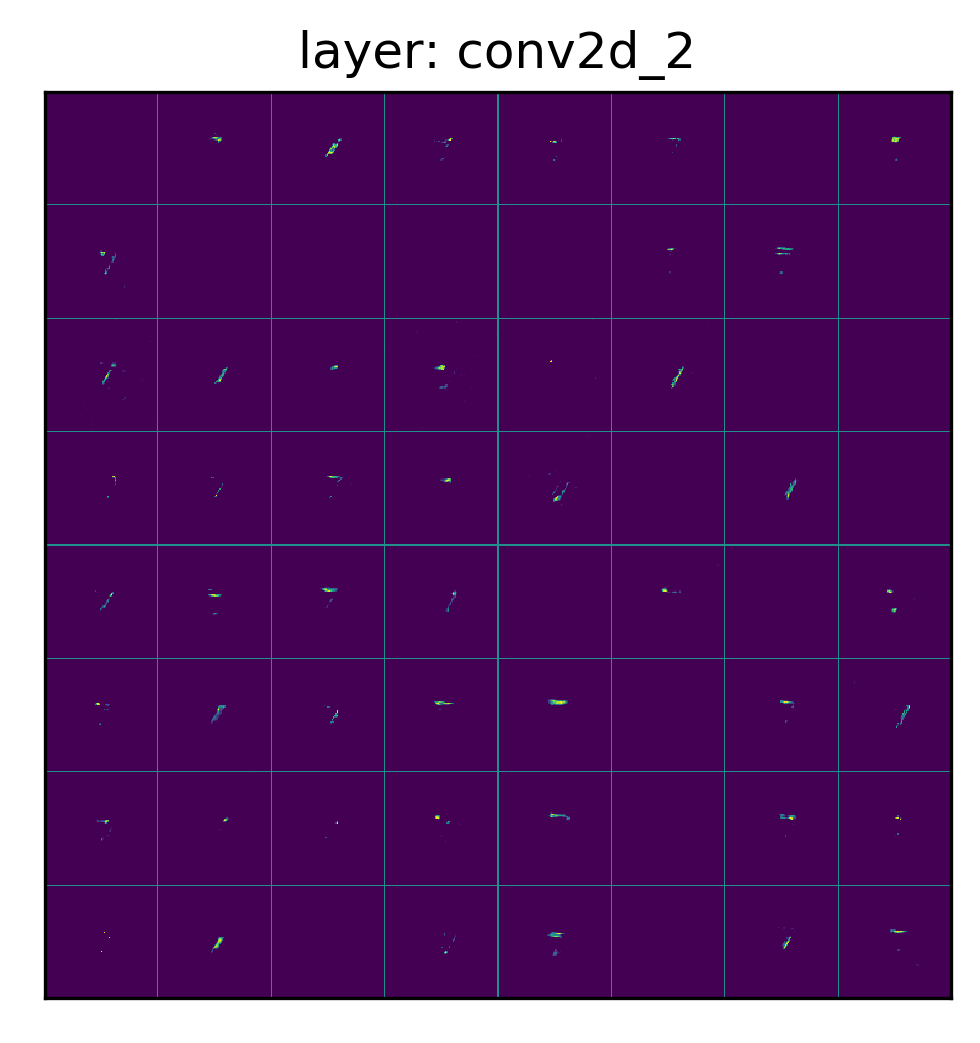

64  channels


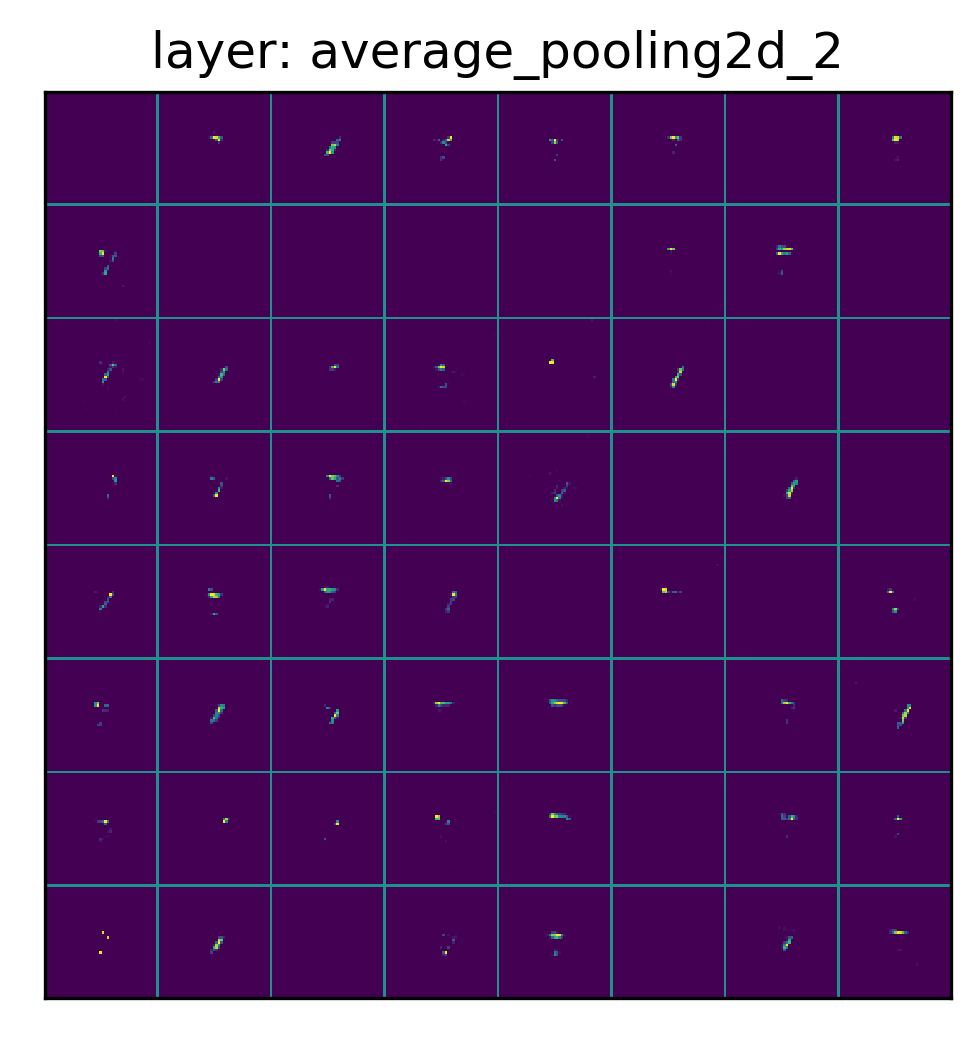

32  channels


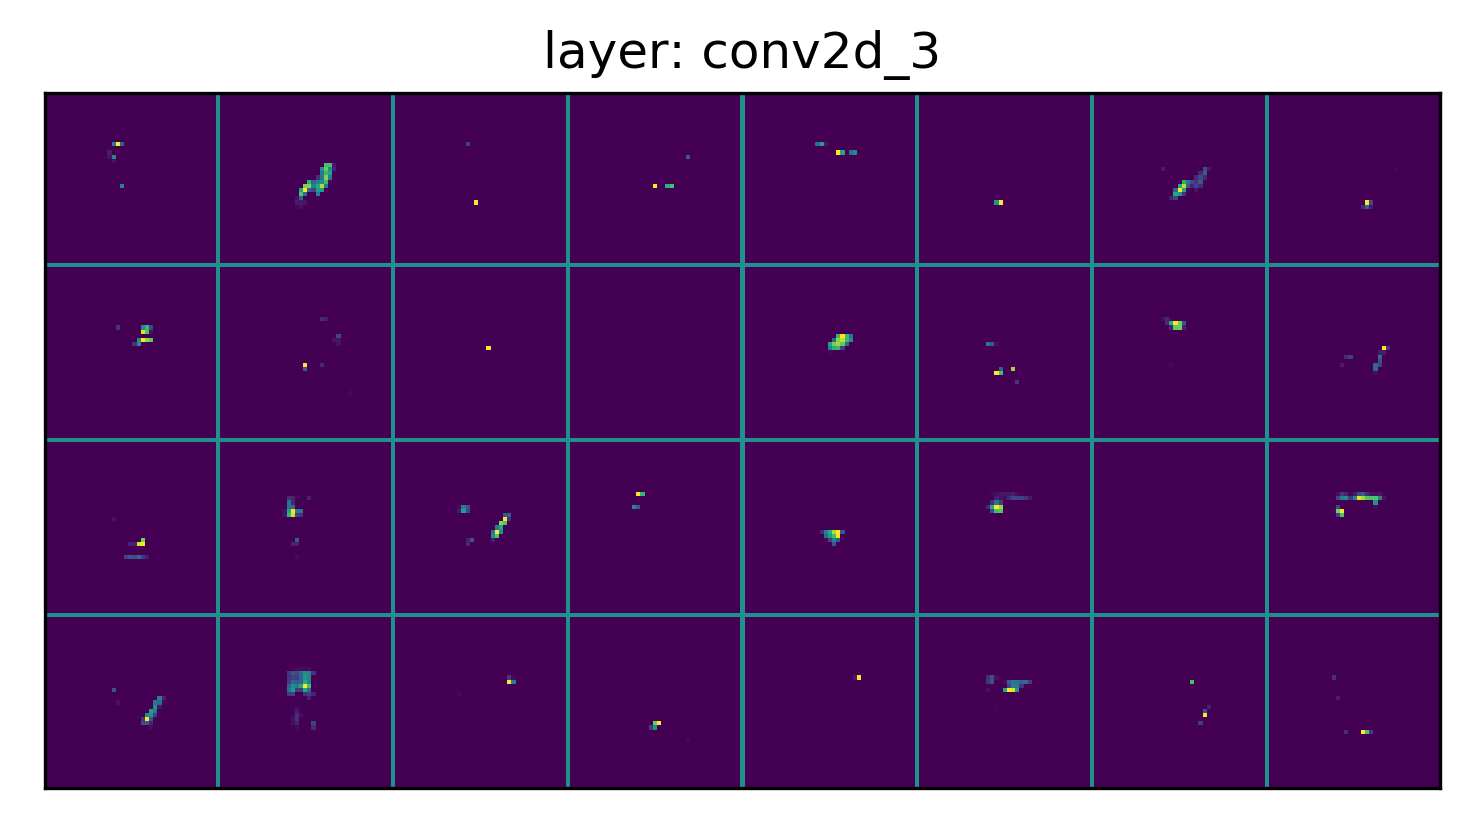

32  channels


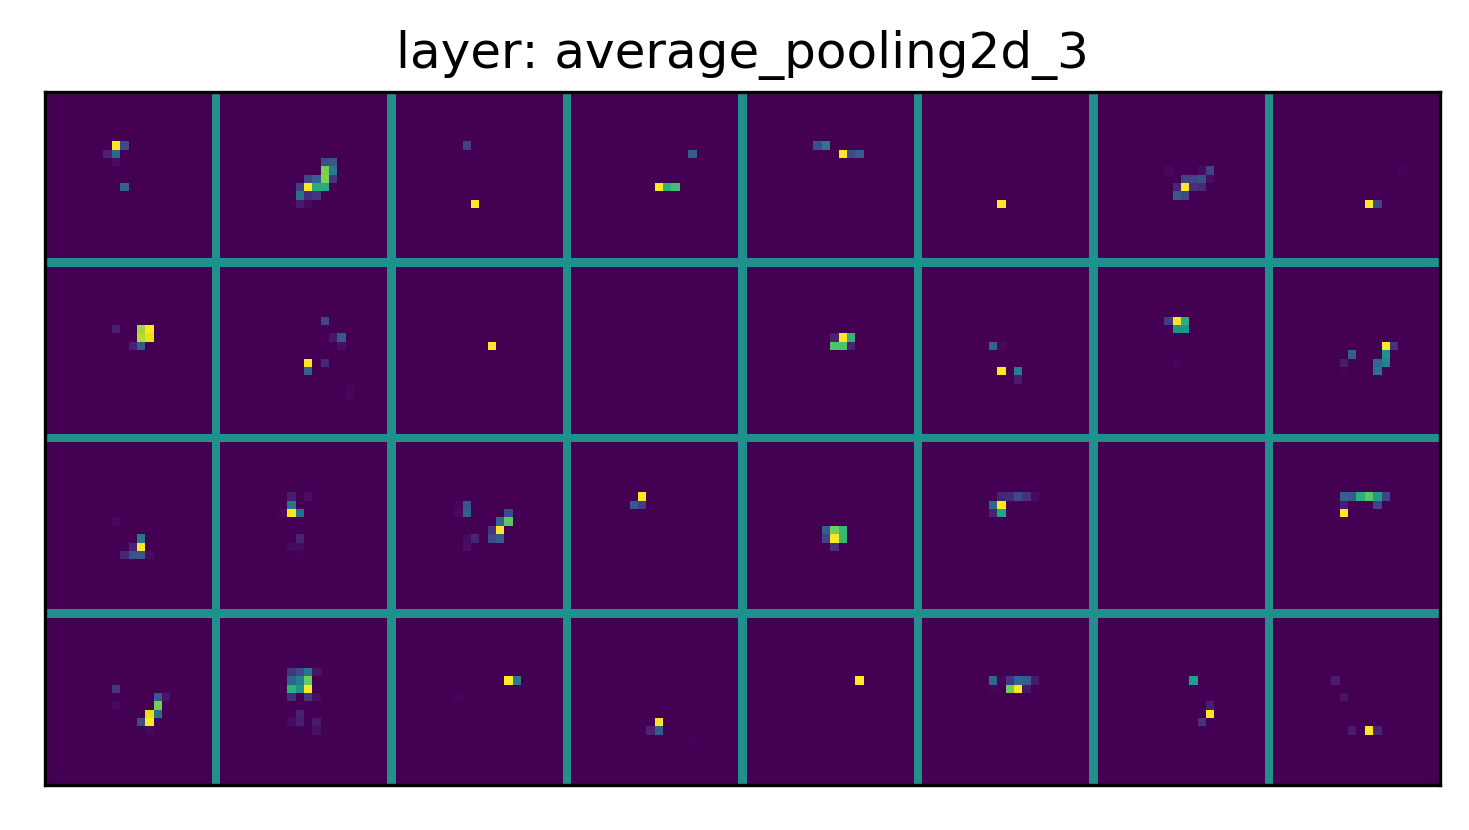

In [5]:
i=0
visualize_activations(new_model, X_test[i], y_test[i])

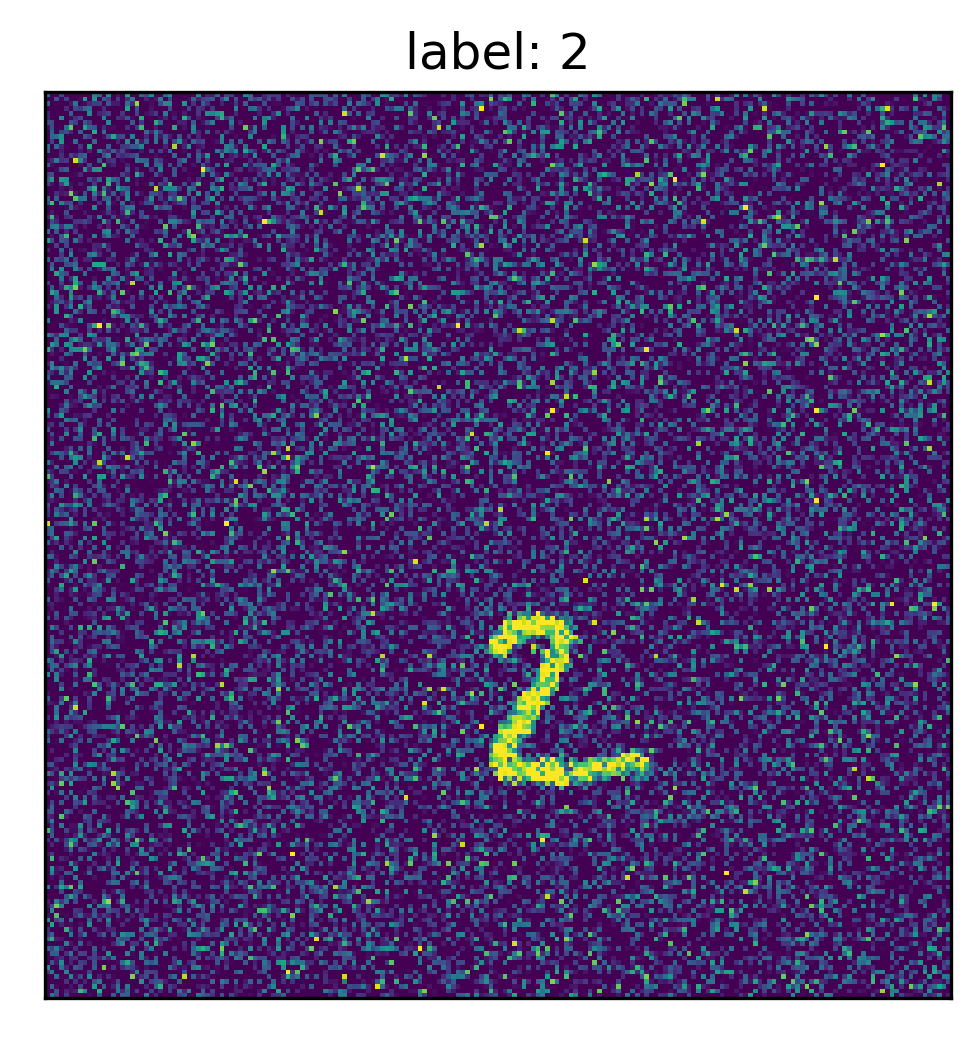

64  channels


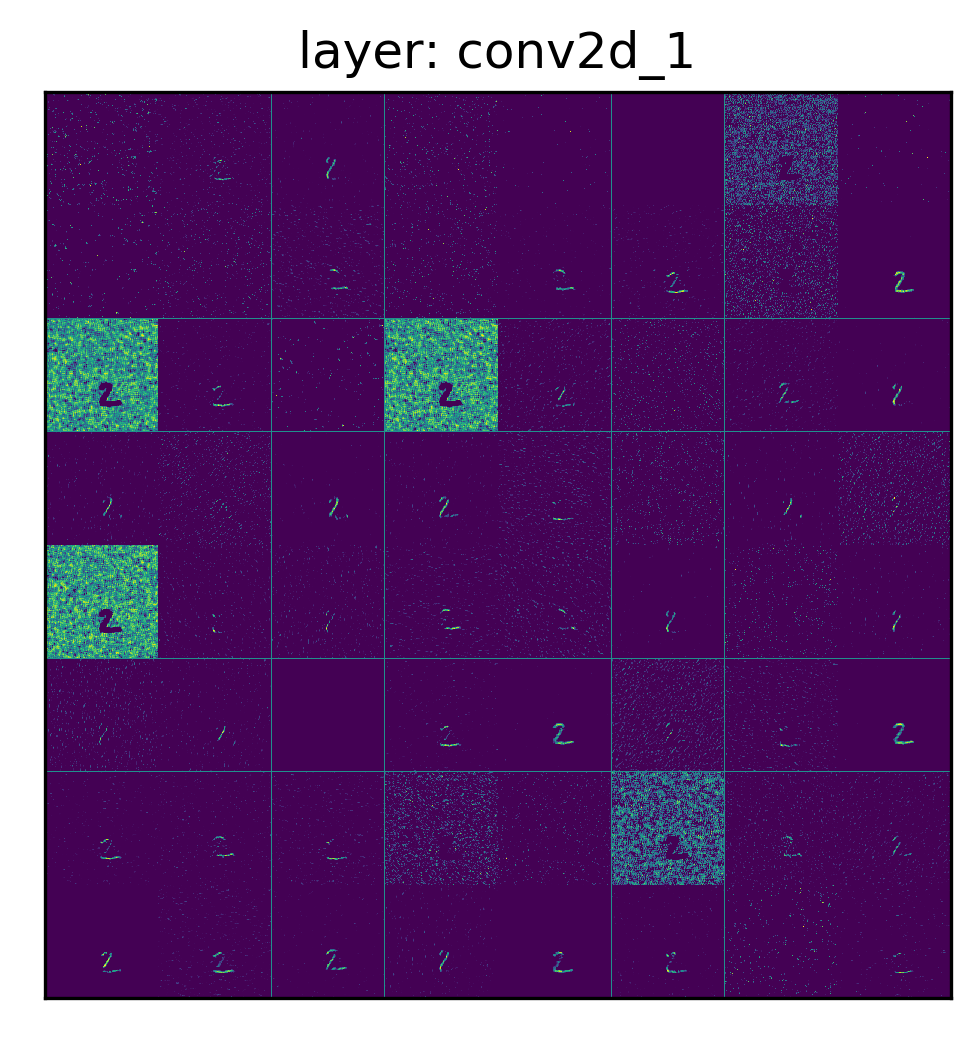

64  channels


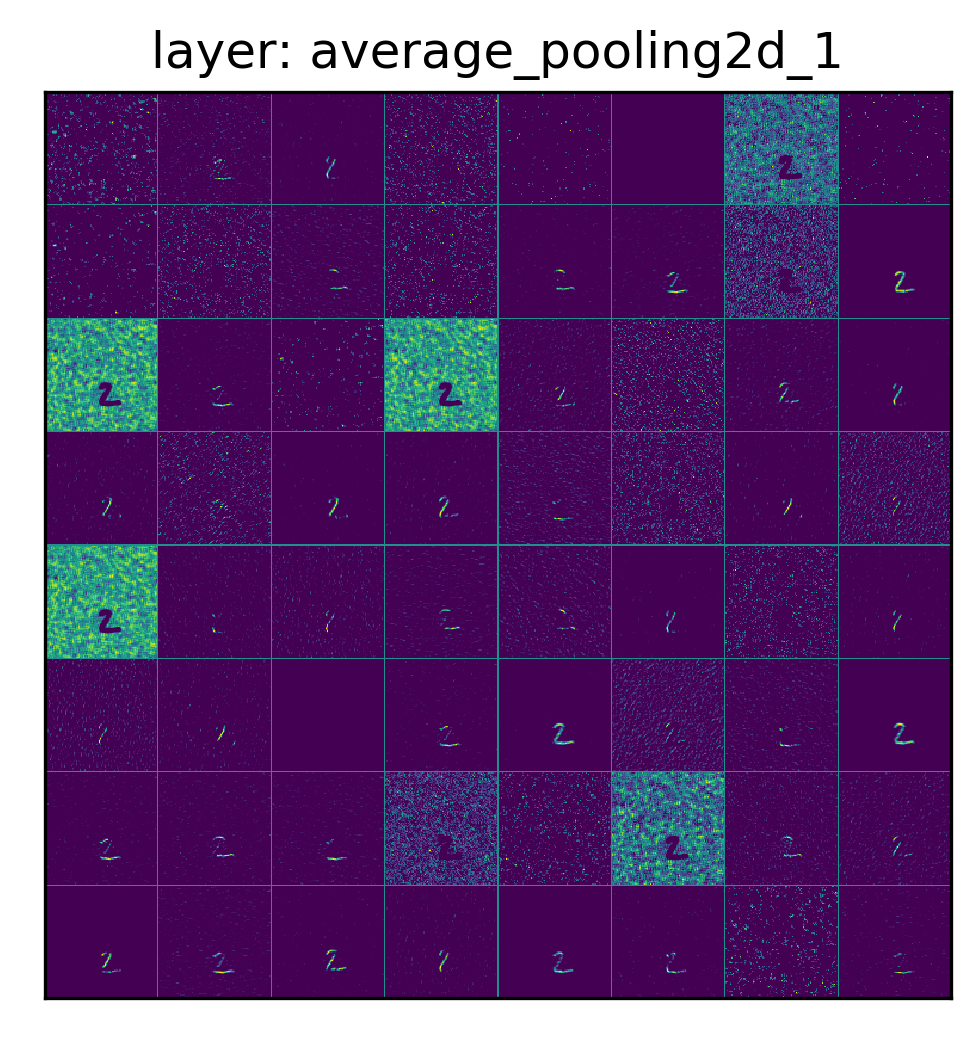

64  channels


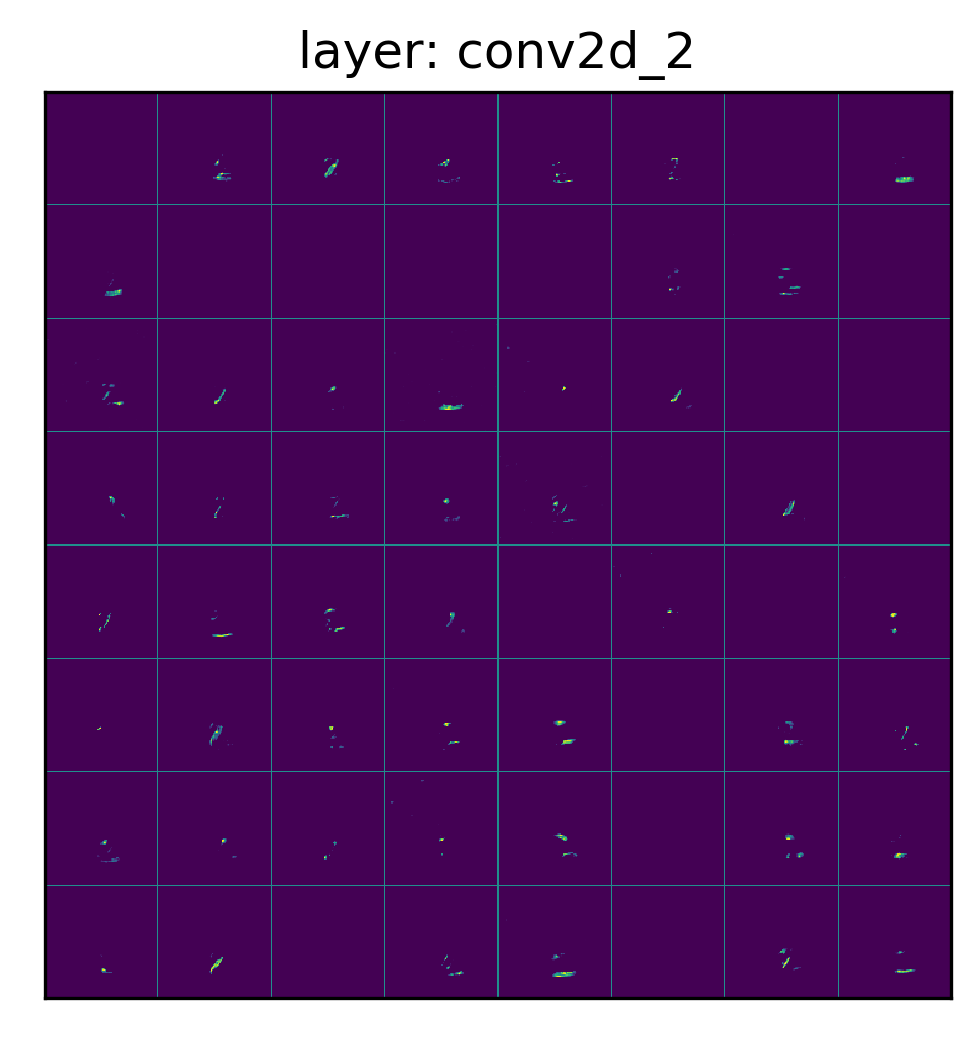

64  channels


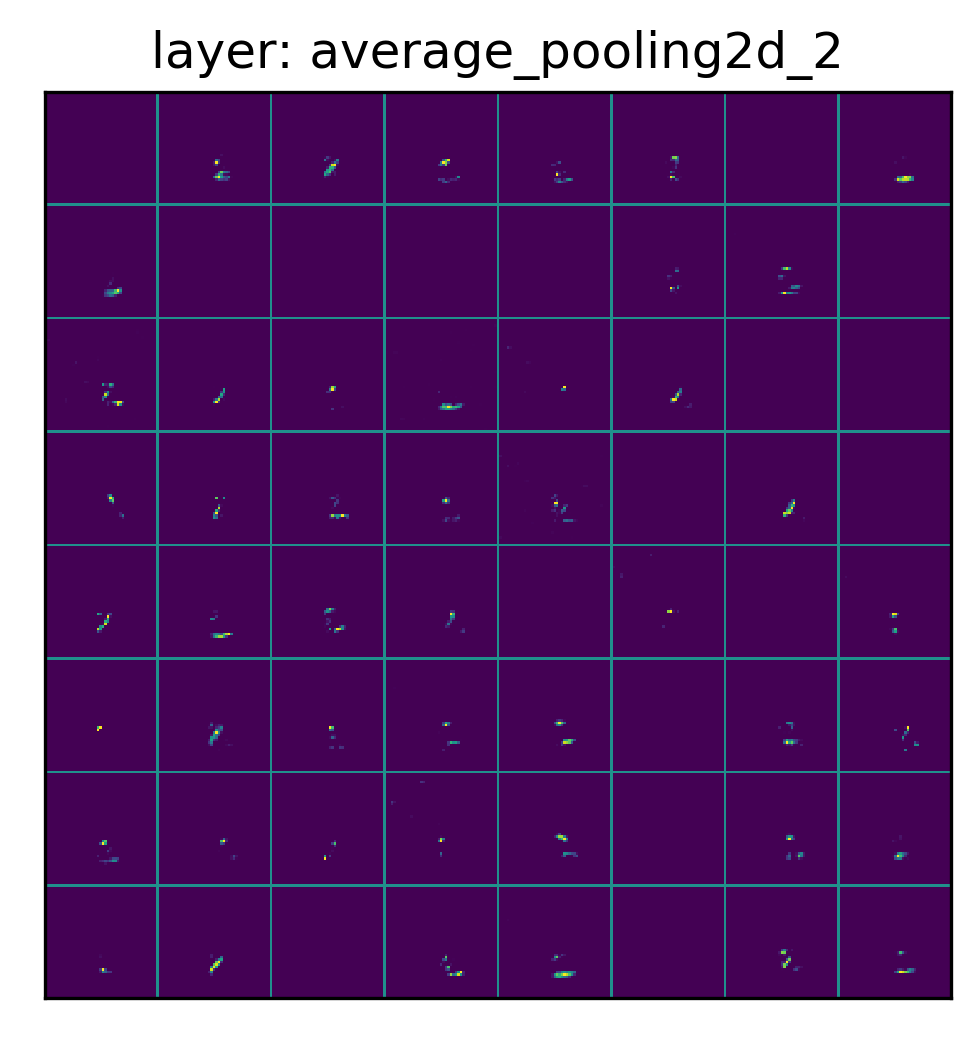

32  channels


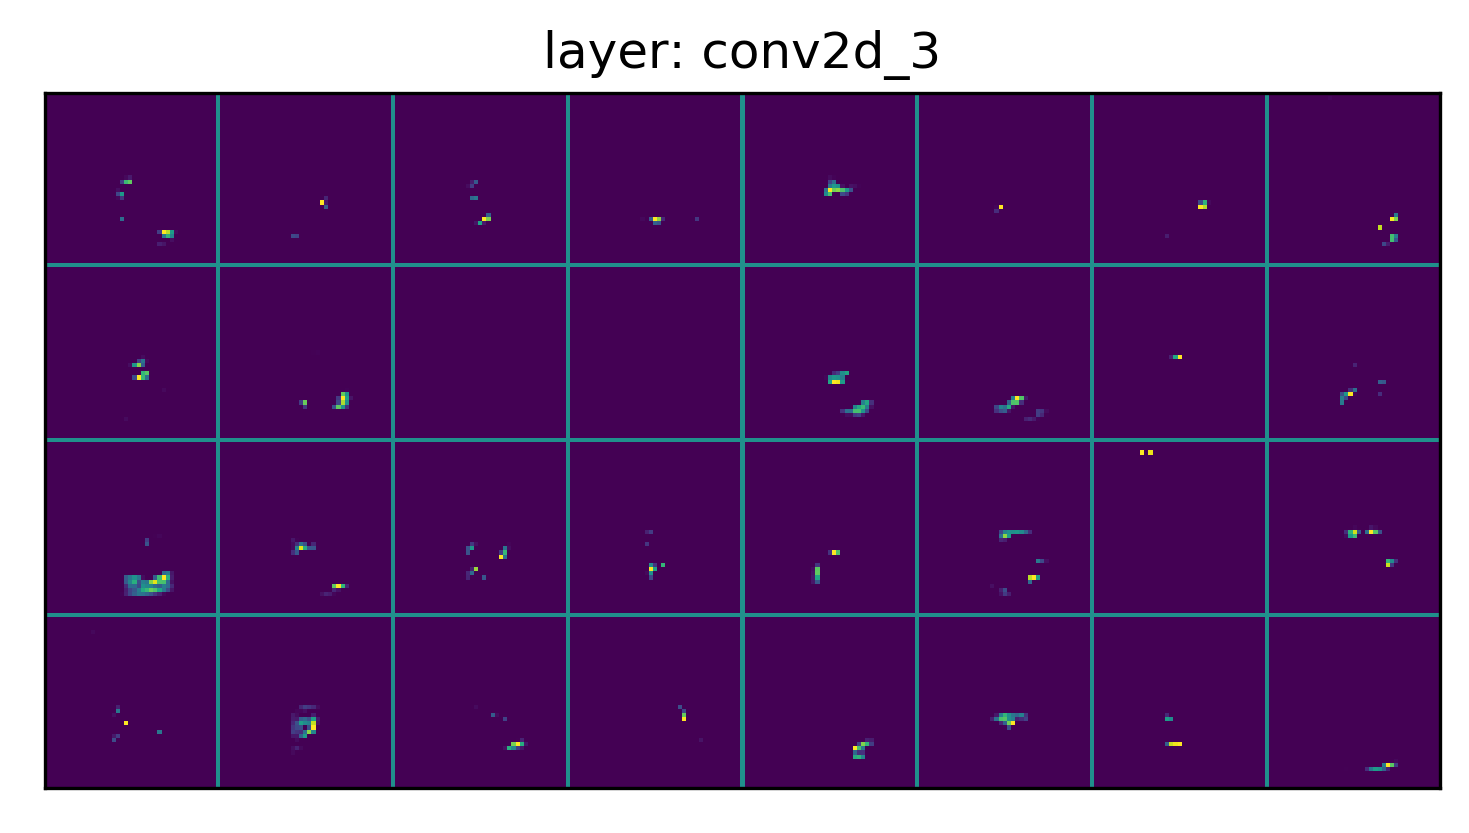

32  channels


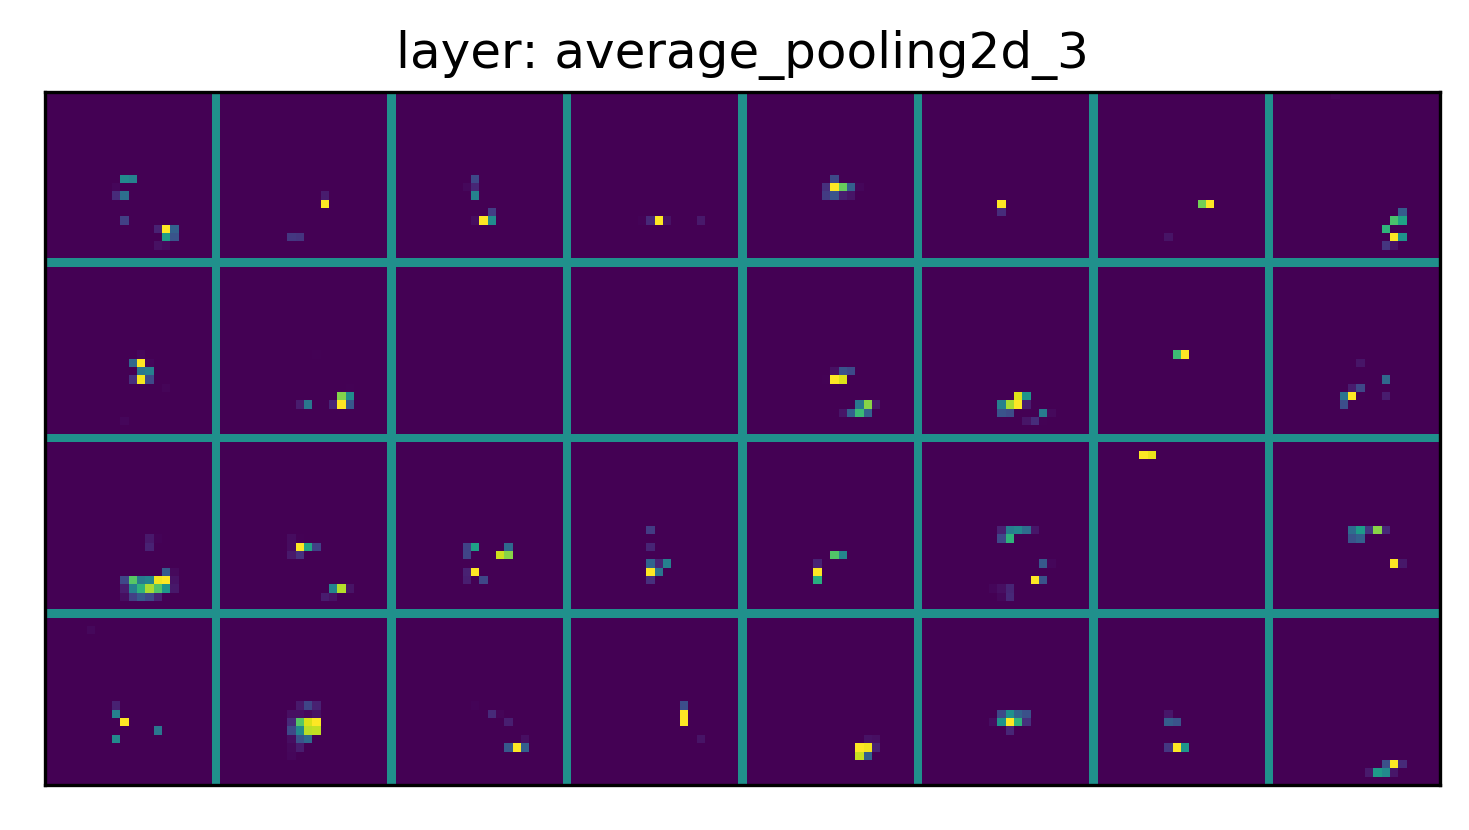

In [6]:
i=1
visualize_activations(new_model, X_test[i], y_test[i])

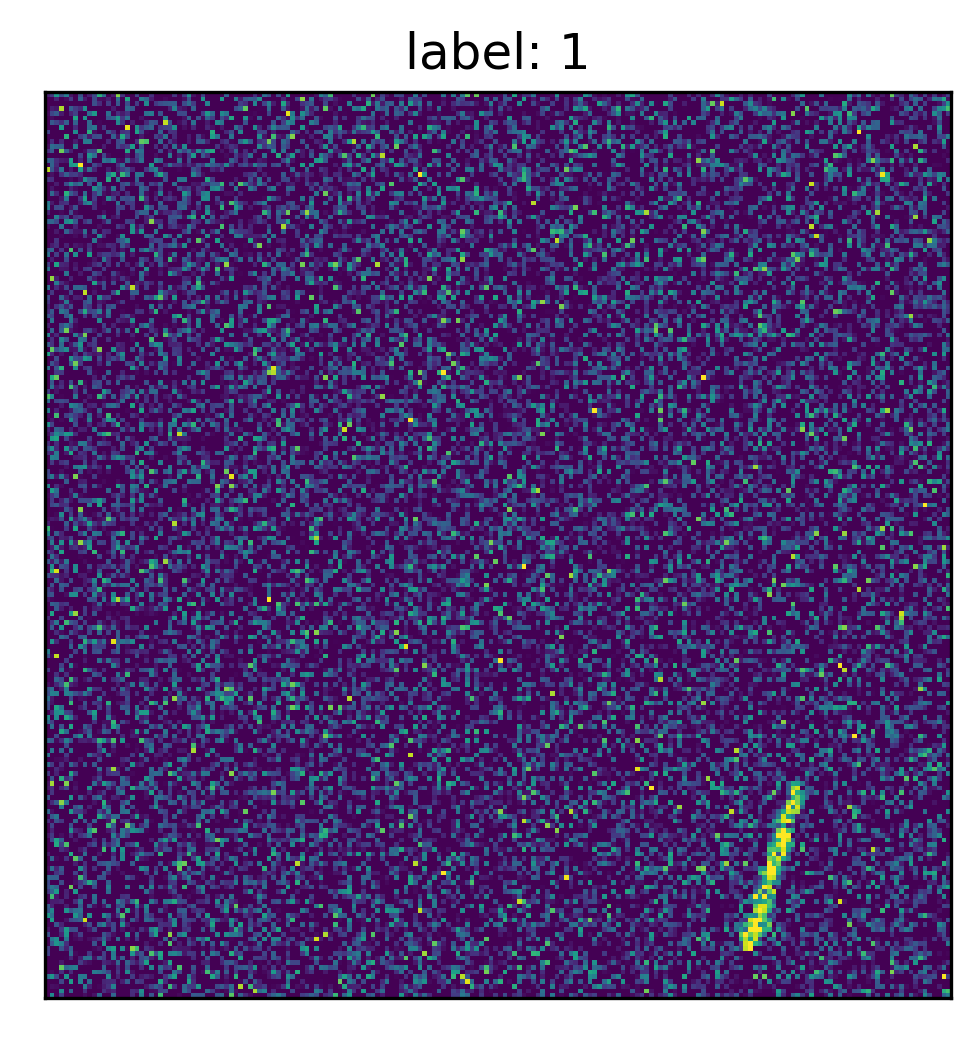

64  channels


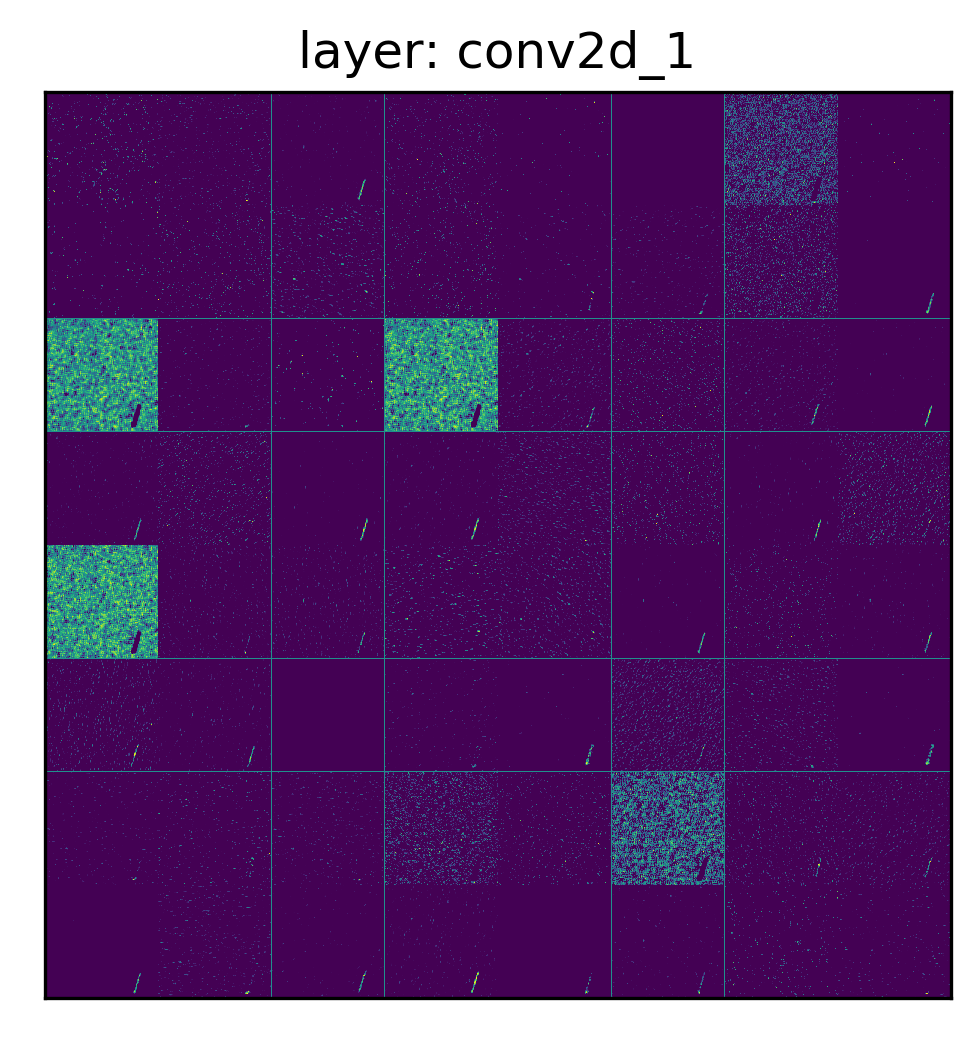

64  channels


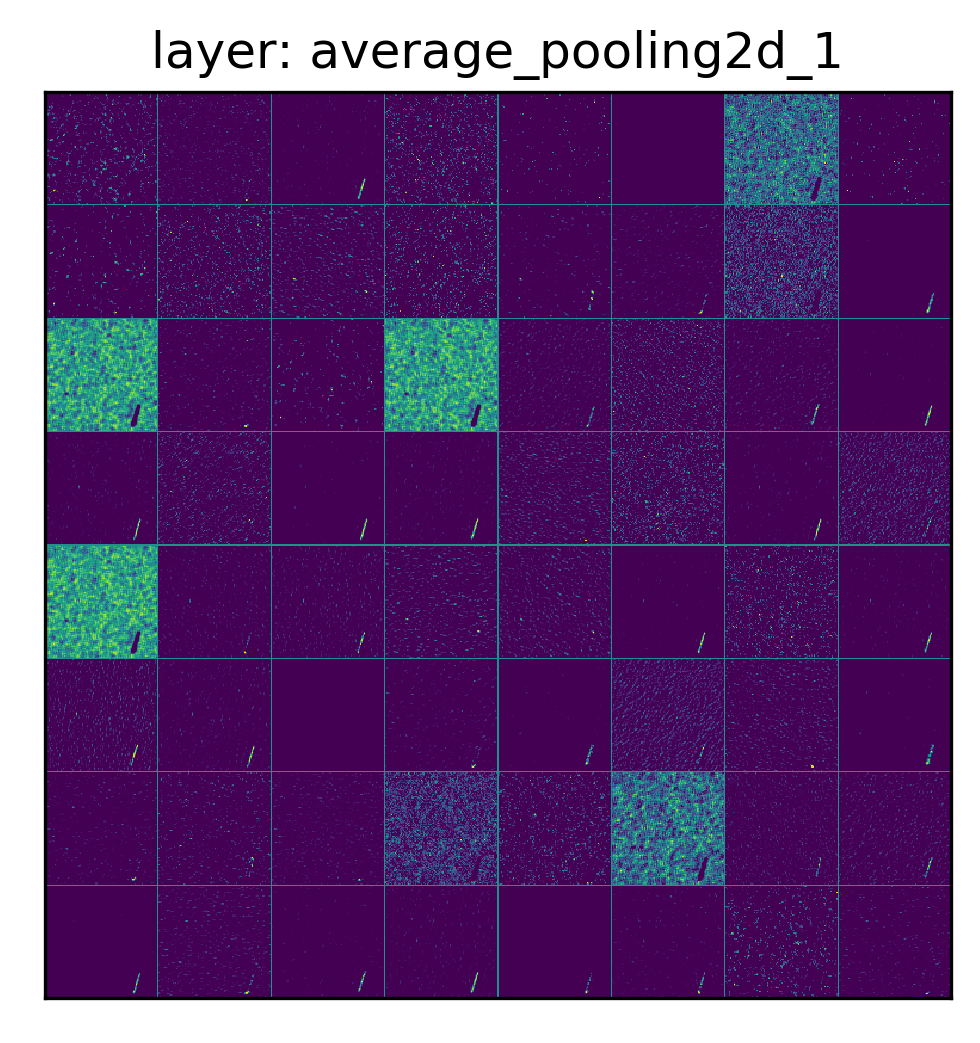

64  channels


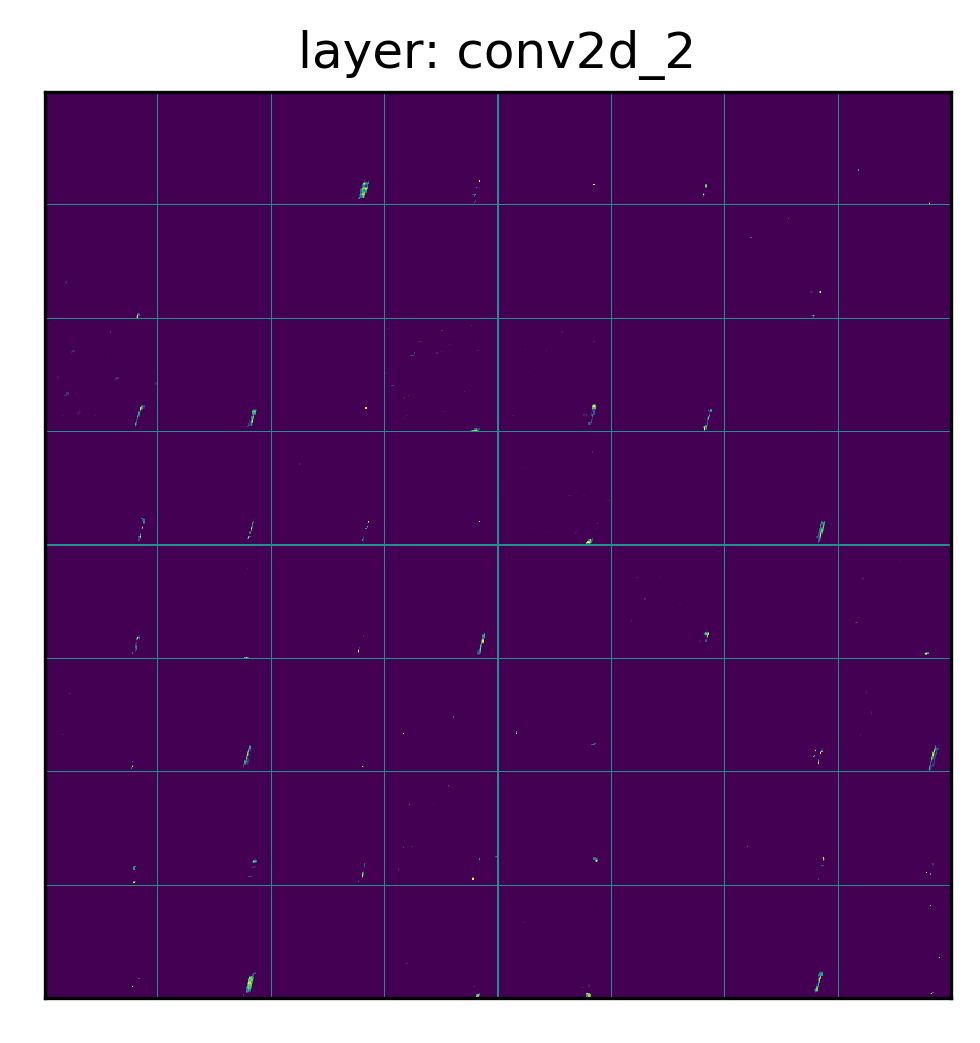

64  channels


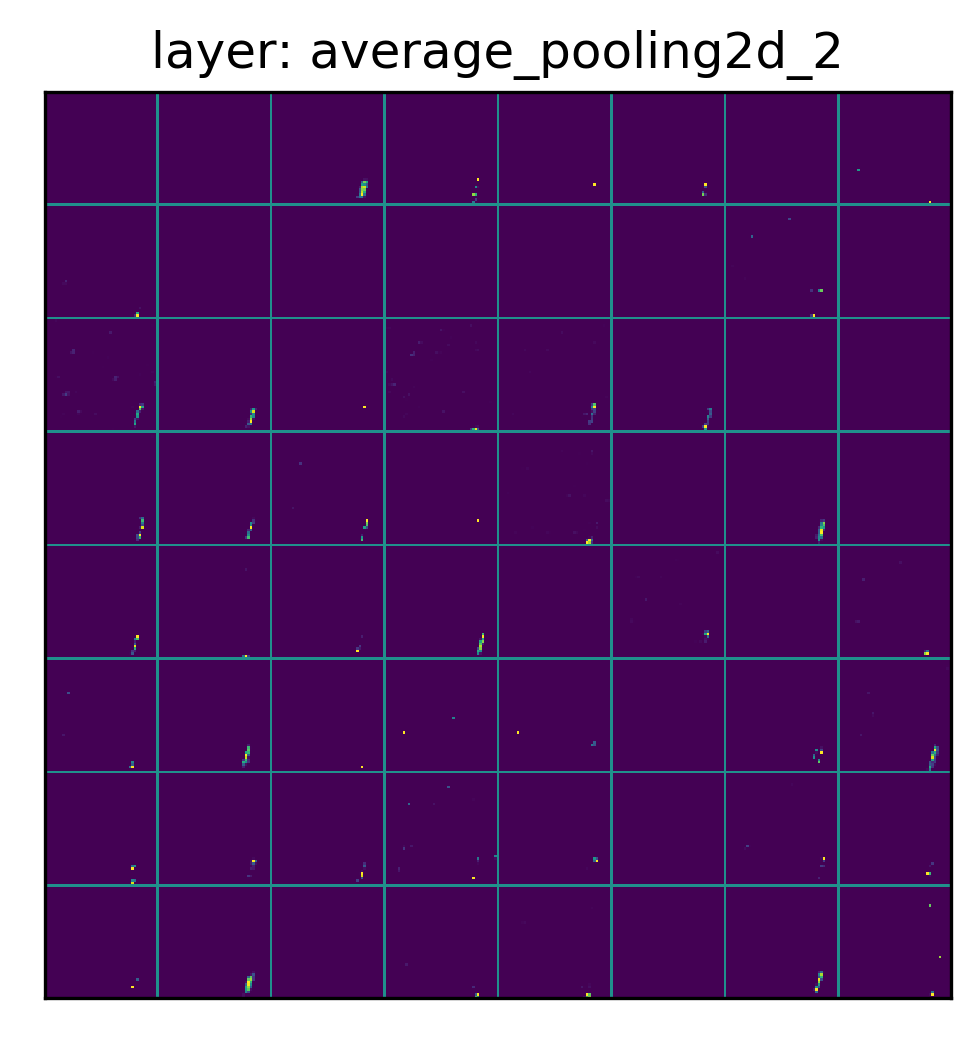

32  channels


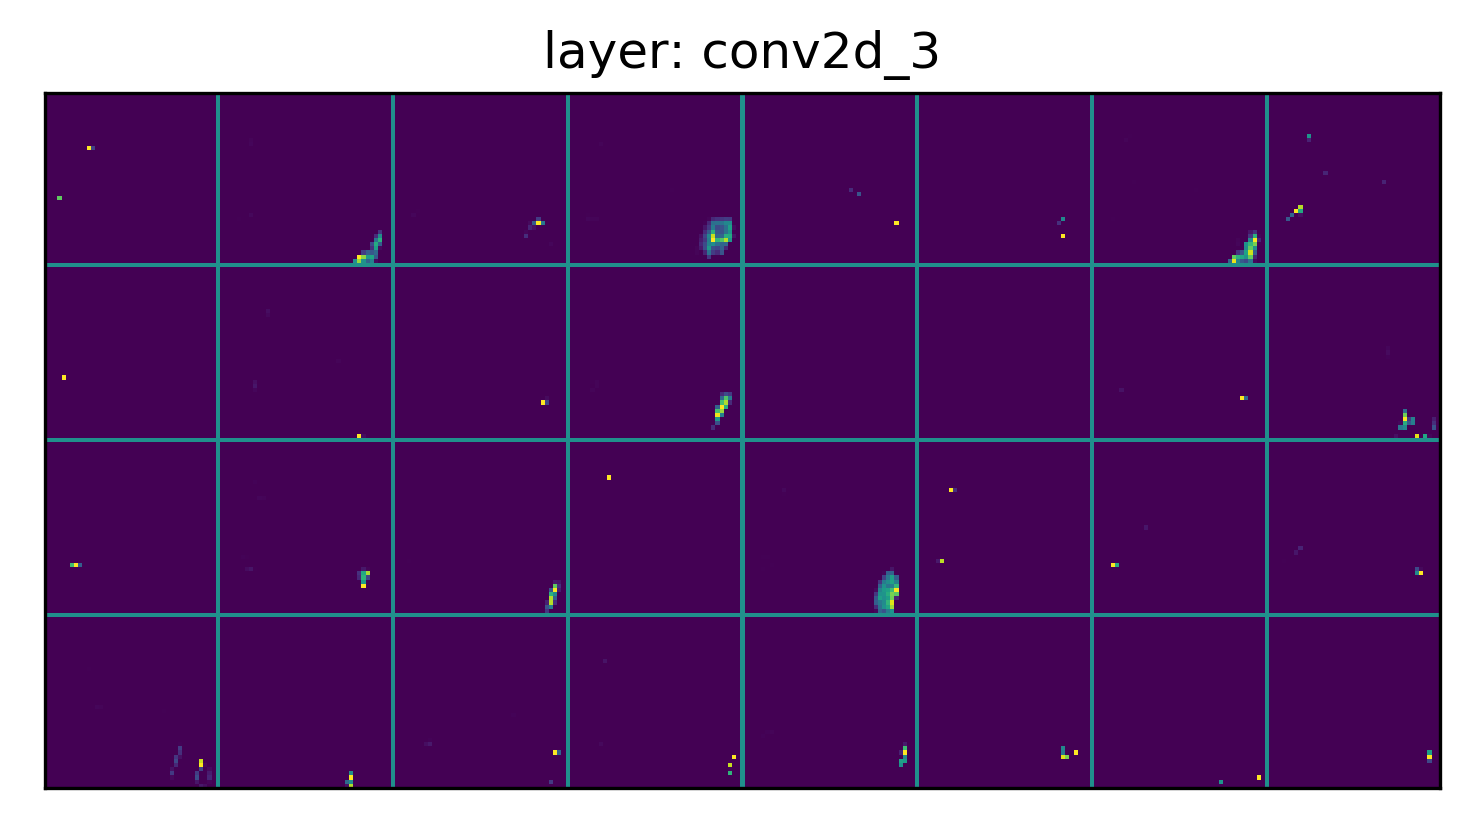

32  channels


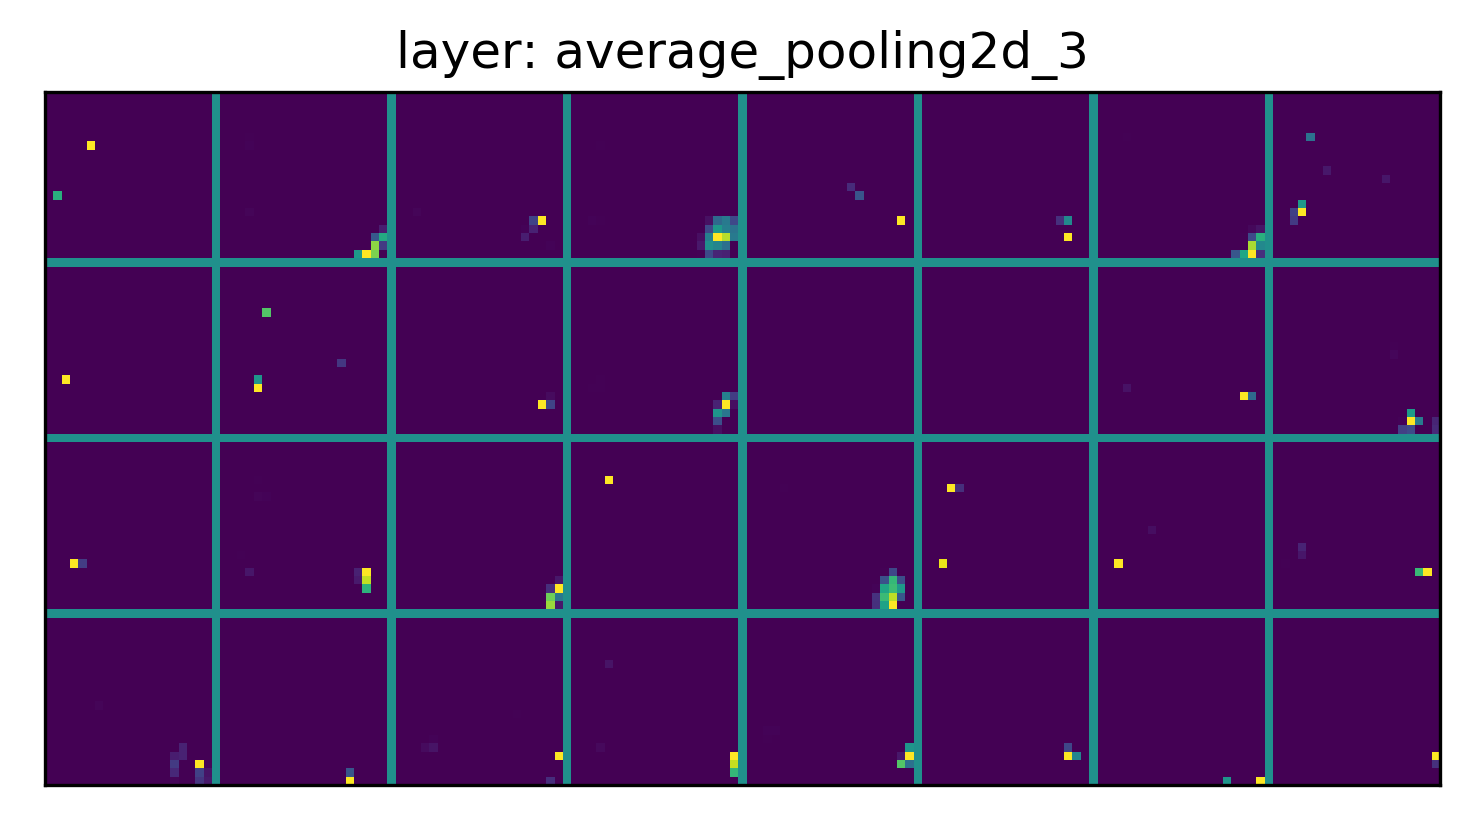

In [7]:
i=2
visualize_activations(new_model, X_test[i], y_test[i])